In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [3]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [4]:
# import data and creating a signal
df_BVP = pd.read_csv('BVP_pp20.csv', header=None)

In [5]:
#counting n rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    224697
dtype: int64


In [6]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

0    224697
dtype: int64
0    3510.890625
dtype: float64
0    58.514844
dtype: float64


In [7]:
#create BVP signal 
fsamp = 64  #64 Hz = 0.015625 s(p)
ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')
tstart_df_BVP = 100 #s

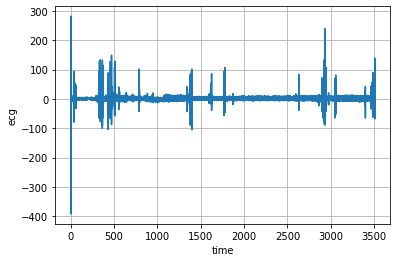

In [8]:
ecg.plot()

In [9]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

# save data 
outputFile=open("time_pp20_BVP.txt", 'a')
outputFile.write("{}\n{}\n".format(walk_time_seconds, walk_time_minutes))
outputFile.close()


0    224697
dtype: int64
0    3510.890625
dtype: float64
0    58.514844
dtype: float64


In [37]:
ibi = ph.BeatFromECG()(ecg)

In [38]:
ibi.get_duration() 

3590.8125

In [10]:
# create label
label = np.zeros(3510)
label[0:600] = 1
label[600:3510] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [11]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [12]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [13]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

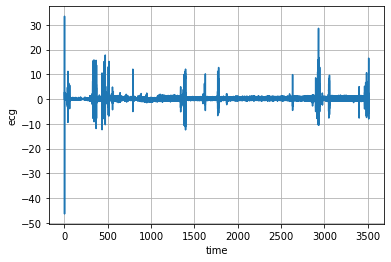

In [14]:
ecg.plot()

In [15]:
ibi = ph.BeatFromECG()(ecg)

In [16]:
ibi.get_duration()


3510.890625

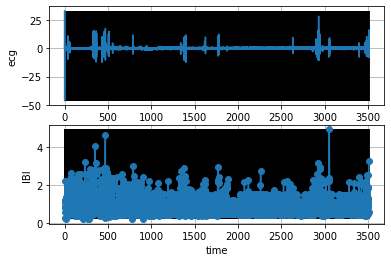

In [17]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [18]:
### physiological indicators 

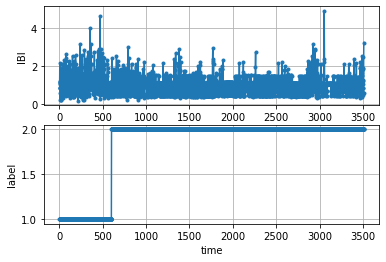

In [19]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()


In [20]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [21]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [22]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c2e19ff50>,
 'caps': [<matplotlib.lines.Line2D at 0x1c2e1a99d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c2e19f290>,
 'medians': [<matplotlib.lines.Line2D at 0x1c24dd7250>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c2e1ad950>,
 'means': []}

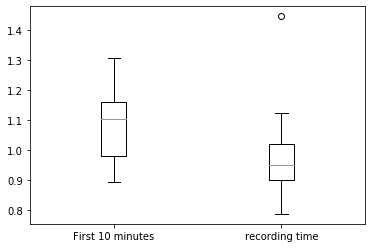

In [23]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['First 10 minutes', 'recording time'])

In [26]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [27]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [28]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp20_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp20_df.head()

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.228516,61.228516,1.0,152.632585,403.439012,709.406522,1914.449623
1,61.228516,121.228516,1.0,164.508876,463.694676,887.768609,2248.582353
2,121.228516,181.228516,1.0,153.915343,606.334843,770.686190,2218.223095
3,181.228516,241.228516,1.0,218.946724,530.578574,824.505751,2273.558070
4,241.228516,301.228516,1.0,244.643390,428.240623,610.922043,2018.605857


In [31]:
#save data
FD_HRV_pp20_df.to_csv('FD_HRV_pp20.csv')